So far our machine learning model does not work very well with TWF

What if we simply use an ensemble of decision stumps.

Combine multiple simple classifier to hopefully create a powerful one

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [3]:

X_train=pd.read_csv('X_train.csv')
y_train=pd.read_csv('y_train.csv')
X_test=pd.read_csv('X_test.csv')
y_test=pd.read_csv('y_test.csv')
df_train=pd.concat([X_train, y_train], axis=1)
df_test=pd.concat([X_test, y_test], axis=1)

y_train_omf = y_train['Machine failure']
y_test_omf = y_test['Machine failure']
y_train_over_omf = pd.read_csv('y_smote_train.csv')
X_train_over_omf = pd.read_csv('X_smote_train.csv')

X_train_reduced = X_train.drop(columns=['Torque (Nm)', 'Process temperature (K)', 'Air temperature (K)'])
X_test_reduced = X_test.drop(columns=['Torque (Nm)', 'Process temperature (K)', 'Air temperature (K)'])
X_train_over_reduced = X_train_over_omf.drop(columns=['Torque (Nm)', 'Process temperature (K)', 'Air temperature (K)'])

y_ros_train = pd.read_csv('y_ros_train.csv')
X_ros_train = pd.read_csv('X_ros_train.csv')
X_ros_train_reduced = pd.read_csv('X_ros_train_reduced.csv')

print("Shape of X_train:", X_train.shape)
print("Shape of X_test:", X_test.shape)
print("Shape of X_train_reduced:", X_train_reduced.shape)
print("Shape of X_test_reduced:", X_test_reduced.shape)
print("Shape of X_train_over_reduced:", X_train_over_reduced.shape)
print("Shape of y_train:", y_train.shape)
print("Shape of y_test:", y_test.shape)
print("Shape of y_train_omf:", y_train_omf.shape)
print("Shape of y_test_omf:", y_test_omf.shape)
print("Shape of y_train_over_omf:", y_train_over_omf.shape)
print("Shape of X_train_over_omf:", X_train_over_omf.shape)
print("Shape of y_ros_train:", y_ros_train.shape)
print("Shape of X_ros_train:", X_ros_train.shape)


Shape of X_train: (8000, 9)
Shape of X_test: (2000, 9)
Shape of X_train_reduced: (8000, 6)
Shape of X_test_reduced: (2000, 6)
Shape of X_train_over_reduced: (15444, 6)
Shape of y_train: (8000, 6)
Shape of y_test: (2000, 6)
Shape of y_train_omf: (8000,)
Shape of y_test_omf: (2000,)
Shape of y_train_over_omf: (15444, 1)
Shape of X_train_over_omf: (15444, 9)
Shape of y_ros_train: (15228, 6)
Shape of X_ros_train: (15228, 9)


In [20]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, fbeta_score, precision_score, recall_score, accuracy_score
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix
import matplotlib.pyplot as plt
from sklearn.model_selection import StratifiedKFold, cross_val_score
from sklearn.metrics import fbeta_score, make_scorer


def analyze_model_performance(clf, X_train=X_train, y_train=y_train, X_test=X_test, y_test=y_test, target='Machine failure'):
    y_train_omf = y_train[target]
    y_test_omf = y_test[target]
    f2_scorer = make_scorer(fbeta_score, beta=2)    
    stratified_cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    cv_accuracy = cross_val_score(clf, X_train, y_train_omf, cv=stratified_cv, scoring='accuracy') # 5-fold cross-validation
    cv_f2 = cross_val_score(clf, X_train, y_train_omf, cv=stratified_cv, scoring=f2_scorer) # 5-fold cross-validation
    cv_accuracy_mean = cv_accuracy.mean()
    cv_f2_mean = cv_f2.mean()
    clf.fit(X_train, y_train_omf)
    y_train_pred_omf = clf.predict(X_train)[target]
    y_test_pred_omf = clf.predict(X_test)[target]
    f2_train=fbeta_score(y_train_omf, y_train_pred_omf, beta=2)
    f2_test=fbeta_score(y_test_omf, y_test_pred_omf, beta=2)
    train_recall=recall_score(y_train_omf, y_train_pred_omf)
    test_recall=recall_score(y_test_omf, y_test_pred_omf)
    train_precision=precision_score(y_train_omf, y_train_pred_omf, zero_division=0)
    test_precision=precision_score(y_test_omf, y_test_pred_omf,  zero_division=0)
    train_accuracy=accuracy_score(y_train_omf, y_train_pred_omf)
    test_accuracy=accuracy_score(y_test_omf, y_test_pred_omf)
    predictor_name = clf.__class__.__name__


    plt.figure(figsize=(15, 5))
    cm = confusion_matrix(y_train_omf, y_train_pred_omf)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['No Failure', 'Failure'])
    disp.plot(cmap=plt.cm.Blues, ax=plt.subplot(1, 2, 1))
    plt.title(f'{predictor_name} on Train Data')
    cm = confusion_matrix(y_test_omf, y_test_pred_omf)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['No Failure', 'Failure'])
    disp.plot(cmap=plt.cm.Blues, ax=plt.subplot(1, 2, 2))
    plt.title(f'{predictor_name} on Test Data')
    plt.show()



    print(" For `Machine failure` label:")
    print(predictor_name, " :")
    print(f"- CV F2 Score on Training Data: {cv_f2_mean}")
    print(f"- CV Accuracy on Training Data: {cv_accuracy_mean}")

    print(f"- F2 Score on Training Data: {f2_train}")
    print(f"- F2 Score on Test Data: {f2_test}")
    print(f"- Accuracy on Training Data: {train_accuracy}")
    print(f"- Accuracy on Test Data: {test_accuracy}")
    print(f"- Recall on Training Data: {train_recall}")
    print(f"- Recall on Test Data: {test_recall}")
    print(f"- Precision on Training Data: {train_precision}")
    print(f"- Precision on Test Data: {test_precision}")


In [21]:
import pandas as pd
import numpy as np

# TWF fail if Tool Wear (Min) > 198
# OSF fail if Strain (minNm) >= 110003.2
# HDF Fail if Rotational Speed (rpm) <= 1379 and Temperature Difference <=8.599999999999966
# PWF fail if Power (W) <= 3521.78819652723 or Power (W) >= 8998.024014705741
class ThresholdPredictor:
    def __init__(self):
        self.power_feature = 'Power (W)'
        self.power_low_threshold = 3521.78819652723 # the minimum power where PWF Occurs
        self.power_high_threshold = 8998.024014705741 # the maximum power where PWF Occurs
        self.strain_feature = 'Strain (minNm)'
        self.strain_threshold = 110003.2# the minimum strain where OSF Occurs
        self.temperature_feature = 'Temperature Difference (K)'
        self.temperature_threshold = 8.599999999999966# the minimum temperature difference when HDF occurs
        self.rotational_speed_feature = 'Rotational speed (rpm)'
        self.rotational_speed_threshold = 1379 # the maximum rotational speed when HDF occurs
        self.tool_wear_feature = 'Tool wear (min)'
        self.tool_wear_threshold = 198 # the minimum tool wear when TWF occurs
        self.y_columns = ['Machine failure', 'TWF', 'HDF', 'PWF', 'OSF', 'RNF']
    def fit(self, X, y):
        pass  # No fitting needed for threshold-based model
    def get_params(self, deep=False):
        return {}
    def predict(self, X):
        df = pd.DataFrame(columns=self.y_columns)
        df['PWF'] = np.where(
            (X[self.power_feature] <= self.power_low_threshold) |
            (X[self.power_feature] >= self.power_high_threshold), 1, 0)
        df['HDF'] = np.where(
            (X[self.rotational_speed_feature] <= self.rotational_speed_threshold) &
            (X[self.temperature_feature] <= self.temperature_threshold), 1, 0)
        df['OSF'] = np.where(
            (X[self.strain_feature] >= self.strain_threshold), 1, 0)
        df['RNF'] = pd.Series(0, index=X.index)  # Assuming RNF is not used in this model
        df['TWF'] = np.where(
            (X[self.tool_wear_feature] > self.tool_wear_threshold), 1, 0)
        df['Machine failure'] = df[['TWF', 'HDF', 'PWF', 'OSF']].max(axis=1)
        return df
    def score(self, X, y):
        predictions = self.predict(X)
        return (predictions == y).mean()
    
threshold_predictor = ThresholdPredictor()

# Tool Wear Failure Classifier

/opt/anaconda3/envs/ml/lib/python3.13/site-packages/sklearn/utils/_array_api.py:399: RuntimeWarning: invalid value encountered in cast
  return x.astype(dtype, copy=copy, casting=casting)
/opt/anaconda3/envs/ml/lib/python3.13/site-packages/sklearn/model_selection/_validation.py:978: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/anaconda3/envs/ml/lib/python3.13/site-packages/sklearn/metrics/_scorer.py", line 140, in __call__
    score = scorer._score(
        cached_call, estimator, *args, **routed_params.get(name).score
    )
  File "/opt/anaconda3/envs/ml/lib/python3.13/site-packages/sklearn/metrics/_scorer.py", line 388, in _score
    return self._sign * self._score_func(y_true, y_pred, **scoring_kwargs)
                        ~~~~~~~~~~~~~~~~^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/opt/anaconda3/envs/ml/lib/python3.13/site-packages/sklearn/utils/_param_validat

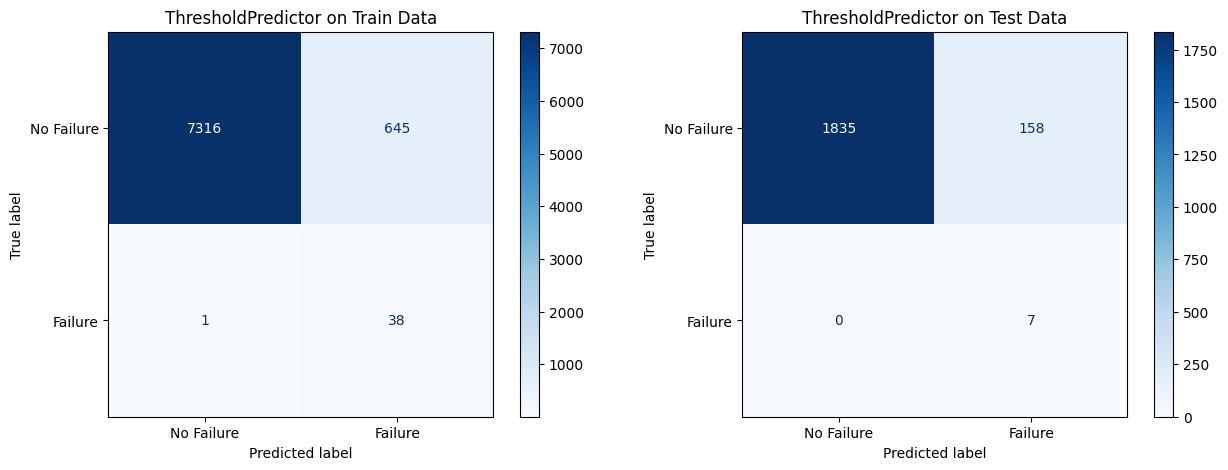

 For `Machine failure` label:
ThresholdPredictor  :
- CV F2 Score on Training Data: nan
- CV Accuracy on Training Data: nan
- F2 Score on Training Data: 0.22646007151370678
- F2 Score on Test Data: 0.18134715025906736
- Accuracy on Training Data: 0.91925
- Accuracy on Test Data: 0.921
- Recall on Training Data: 0.9743589743589743
- Recall on Test Data: 1.0
- Precision on Training Data: 0.055636896046852125
- Precision on Test Data: 0.04242424242424243


In [22]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
twf_dt = DecisionTreeClassifier(random_state=42, max_depth=1)
twf_dt = ThresholdPredictor()
analyze_model_performance(twf_dt, X_train=X_train, y_train=y_train, X_test=X_test, y_test=y_test, target="TWF")